# British Columbia Invasive Plants Identifier

In this notebook, I aim to apply transfer learning methods to a PyTorch image classification CNN (resnet34 specifically) to be able to identify both the species and the level of invasiveness to British Columbia as deemed by https://www2.gov.bc.ca/gov/content/environment/plants-animals-ecosystems/invasive-species/priority-species/priority-plants

Currently, the BC government identifies invasive plants across 5 categories:
1. Prevent:  Species determined to be high risk to BC and not yet established. Management objective is prevent the introduction and establishment.

2. Provincial EDRR: Species is high risk to B.C. and is new to the Province. Management objective is eradication.

3. Provincial Containment: Species is high risk with limited extent in B.C. but significant potential to spread. Management objective is to prevent further expansion into new areas with the ultimate goal of reducing the overall extent.

4. Regional containment/Control: Species is high risk and well established, or medium risk with high potential for spread.  Management objective is to prevent further expansion into new areas within the region through establishment of containment lines and identification of occurrences outside the line to control. 

5. Management: Species is more widespread but may be of concern in specific situations with certain high values - e.g., conservation lands, specific agriculture crops.  Management objective is to reduce the invasive species impacts locally or regionally, where resources are available.

All of these categories could be extremely relevant to a free-to-use plant-indentifier web app. However, in the sake of API costs, resource management, and model complexity, the first version of the model will only be trained to recognize plants under the Provincial Containment category (n=6). As the web app won't be geographically restricted, being able to use it both inside BC and outside BC to identify these plants that have a management objective of limitting outer-provincial occurrences could provide immense value. 


The notebook will walkthrough:
- Data gathering and validation
- Data preprocessing & augmentation via FastAi dataloaders
- Training the model on the new dataset, and using results to further clean the data
- Serving the model as a web app

## Installing Dependencies 

In [4]:
#hide
from fastbook import *
from fastai.vision.widgets import *
import os

## Gathering Data


#### Using Microsoft Azure account for bingAPI search key credentials

In [5]:
# loading azure bingAPI credentials from dotenv
from dotenv import load_dotenv
load_dotenv()
key = os.getenv("AZURE_SEARCH_KEY")

# function of interest details (max images = 150)
search_images_bing


<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [6]:
# Testing out search function on sample search term, validating image return length
results = search_images_bing(key, 'Camelthorn') 
ims = results.attrgot('contentUrl')
len(ims)


150

#### Lets download the first image from the saved search results, validating if we're on the right track

In [7]:
# Create file path and call download_url function
dest = Path('images/test.jpg')
download_url(ims[0], dest)


Path('images/test.jpg')

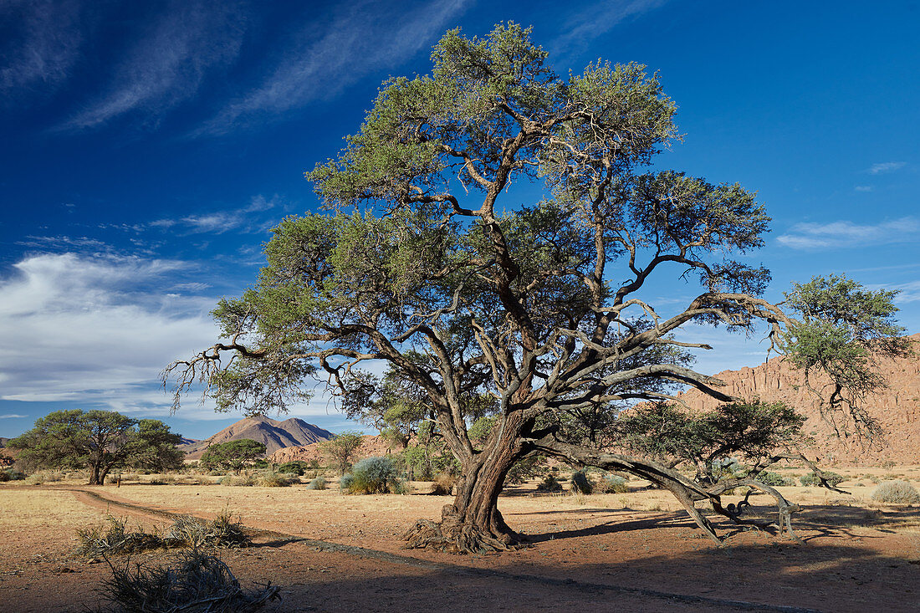

In [8]:
# Open image and resize for better clarity 
im = Image.open(dest)
im.to_thumb(920,920)


#### This seems to have not yielded a super accurate result, further investigating reveals that Camelthorn is both a plant marked as invasive for British Columbia, as well as a tree native to South Africa. To increase the validity of the search results, I'm going to be switching to scientific name following genus-species format.

In [9]:
# Restesting search and image preview with genus-species format instead of common name
results = search_images_bing(key, 'Alhagi maurorum') 
ims = results.attrgot('contentUrl')
len(ims)


150

In [10]:
# Create file path and call download_url function
dest = 'images/test2.jpg'
download_url(ims[0], dest)


Path('images/test2.jpg')

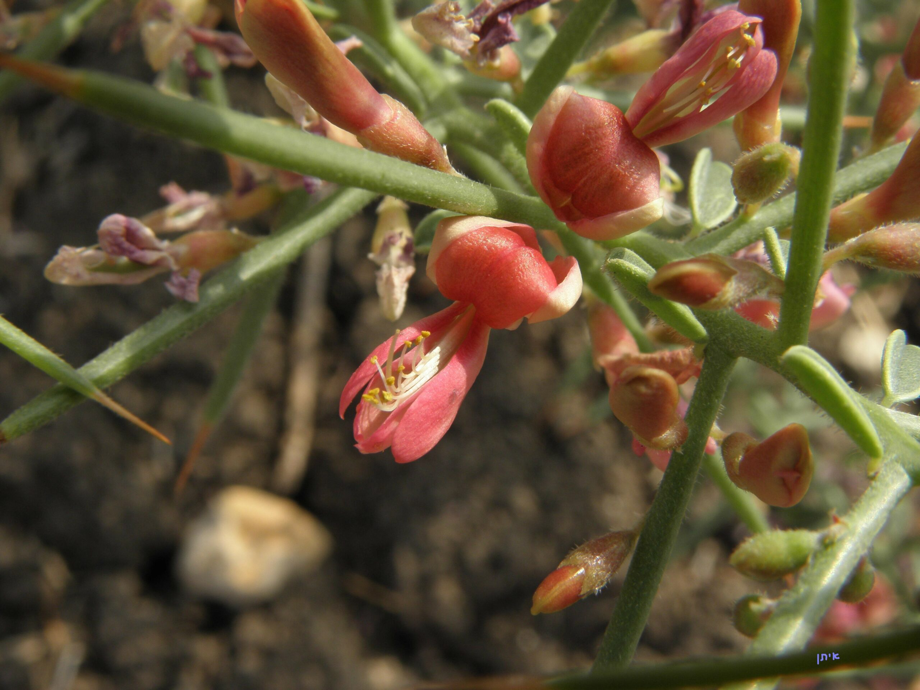

In [11]:
# Open image and resize for better clarity 
im = Image.open(dest)
im.to_thumb(920,920)

#### Much better! We can see now the search result (at least for the first hit) produced what we're actually looking for, which is the Camelthorn plant invasive to BC & not the Camelthorn tree native to South Africa
#### On to the remaining data gathering, which includes grabbing all target plants and saving them in respective folders to streamline the labelling process

In [42]:
# List sourced from https://www2.gov.bc.ca/gov/content/environment/plants-animals-ecosystems/invasive-species/priority-species/priority-plants/plants-table
# Relabelling Provincial Containment as pc from here on out
invasive_pc = 'Alliaria_petiolata', 'Heracleum_mantegazzianum', 'Conium_maculatum', 'Chondrilla_juncea', 'Anthriscus_sylvestris', 'Pastinaca_sativa'
                
path = Path('/notebooks/invasive_plant_identifier/images/')
path

Path('/notebooks/invasive_plant_identifier/images')

#### Here's the simple search engine image scraping code that we'll use to not only scrape all of our target plant pictures, but save them accordingly in folders of their own name

In [43]:
# Create directories for all target plants, saving 150 search result images of each plant in folders of their own name 
# This may take several minutes to complete depending on how many categories you are scraping for

#if not path.exists():
#    path.mkdir()
#    for p in invasive_pc:
#        dest = (path/p)
#        dest.mkdir(exist_ok=True)
#        results = search_images_bing(key, f'{p}')
#        download_images(dest, urls=results.attrgot('contentUrl'))

#### Our folder has image files, as we'd expect:

In [44]:
fns = get_image_files(path)
fns

(#739) [Path('/notebooks/invasive_plant_identifier/images/Alliaria_petiolata/00000047.jpg'),Path('/notebooks/invasive_plant_identifier/images/Alliaria_petiolata/00000055.jpg'),Path('/notebooks/invasive_plant_identifier/images/Alliaria_petiolata/00000061.JPG'),Path('/notebooks/invasive_plant_identifier/images/Alliaria_petiolata/00000126.JPG'),Path('/notebooks/invasive_plant_identifier/images/Alliaria_petiolata/00000107.jpg'),Path('/notebooks/invasive_plant_identifier/images/Alliaria_petiolata/00000036.jpg'),Path('/notebooks/invasive_plant_identifier/images/Alliaria_petiolata/00000097.jpg'),Path('/notebooks/invasive_plant_identifier/images/Alliaria_petiolata/00000148.jpg'),Path('/notebooks/invasive_plant_identifier/images/Alliaria_petiolata/00000110.jpg'),Path('/notebooks/invasive_plant_identifier/images/Alliaria_petiolata/00000029.jpg')...]

#### Often when we download files from the internet, there are a few that are corrupt. Let's check:

In [45]:
failed = verify_images(fns)
len(failed)

0

#### To remove all the failed images, going to use `unlink` on each of them. Note that, like most fastai functions that return a collection, `verify_images` returns an object of type `L`, which includes the `map` method. This calls the passed function on each element of the collection:

In [46]:
failed.map(Path.unlink);

#### And now to do a check to make sure that all unlinked photos didn't belong to one category, as that would wipe out a lot of the training data for that plant

In [47]:
for p in invasive_pc:
    print(f'{p} has {len(get_image_files(path/p))} images --> {150 - len(get_image_files(path/p))} images were removed')

Alliaria_petiolata has 140 images --> 10 images were removed
Heracleum_mantegazzianum has 132 images --> 18 images were removed
Conium_maculatum has 113 images --> 37 images were removed
Chondrilla_juncea has 111 images --> 39 images were removed
Anthriscus_sylvestris has 124 images --> 26 images were removed
Pastinaca_sativa has 119 images --> 31 images were removed


#### It looks like some categories were hit harder in the `unlink` than others, but we'll go on to the next step to see if there's any correlation between model errors and missing training data
#### Now that we have downloaded some data, we need to assemble it in a format suitable for model training. In fastai, that means creating an object called `DataLoaders`.

## From Data to DataLoaders

`DataLoaders` is a thin class that just stores whatever `DataLoader` objects you pass to it, and makes them available as `train` and `valid`. Although it's a very simple class, it's very important in fastai: it provides the data for your model. The key functionality in `DataLoaders` is provided with just these four lines of code:

```python
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])
```

> jargon: DataLoaders: A fastai class that stores multiple `DataLoader` objects you pass to it, normally a `train` and a `valid`, although it's possible to have as many as you like. The first two are made available as properties.

To turn our downloaded data into a `DataLoaders` object we need to tell fastai at least four things:

- What kinds of data we are working with
- How to get the list of items
- How to label these items
- How to create the validation set


In [48]:
# Here is the dataloader for our model, handling the training/val split, setting image labels, resizing images, as well as setting the random seed
plants = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # What kind of data
    get_items=get_image_files, # How to get items 
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # How to create validation set
    get_y=parent_label, # How to get labels
    item_tfms=Resize(128)) # Transformations of images, as all aren't same size

In [49]:
dls = plants.dataloaders(path)

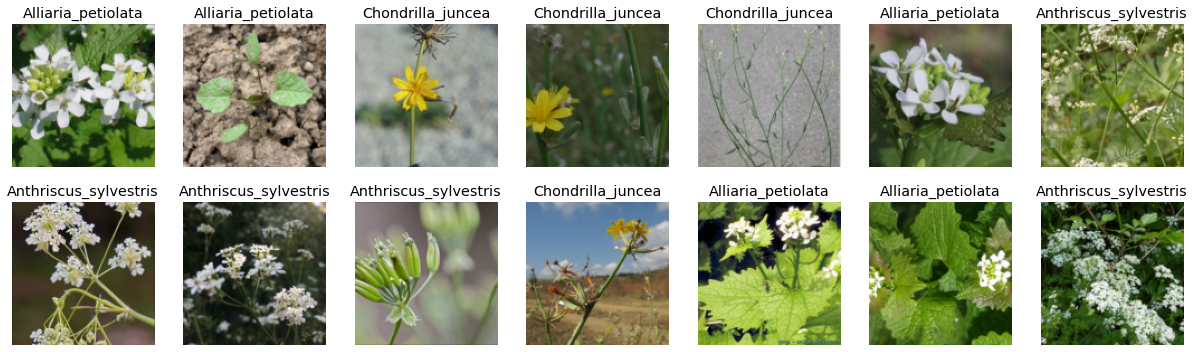

In [50]:
dls.valid.show_batch(max_n=14, nrows=2, unique=False)

### Data Augmentation

*Data augmentation* refers to creating random variations of our input data, such that they appear different, but do not actually change the meaning of the data. Examples of common data augmentation techniques for images are rotation, flipping, perspective warping, brightness changes and contrast changes. For natural photo images such as the ones we are using here, a standard set of augmentations that we have found work pretty well are provided with the `aug_transforms` function. Because our images are now all the same size, we can apply these augmentations to an entire batch of them using the GPU, which will save a lot of time. To tell fastai we want to use these transforms on a batch, we use the `batch_tfms` parameter (note that we're not using `RandomResizedCrop` in this example, so you can see the differences more clearly; we're also using double the amount of augmentation compared to the default, for the same reason):

#### Now that we have assembled our data in a format fit for model training, let's actually train an image classifier using it.

## Training Your Model, and Using It to Clean Your Data

We don't have a lot of data for our problem (<150 pictures of each plant), so to train our model, we'll use `RandomResizedCrop` with an image size of 224 px, which is fairly standard for image classification, and default `aug_transforms`:

#### We're going to start with these parameters as a benchmark, then we'll go through fine tuning the model, evaluating the error_rates & plotting a confusion matrix of the predictions, and working up from there!

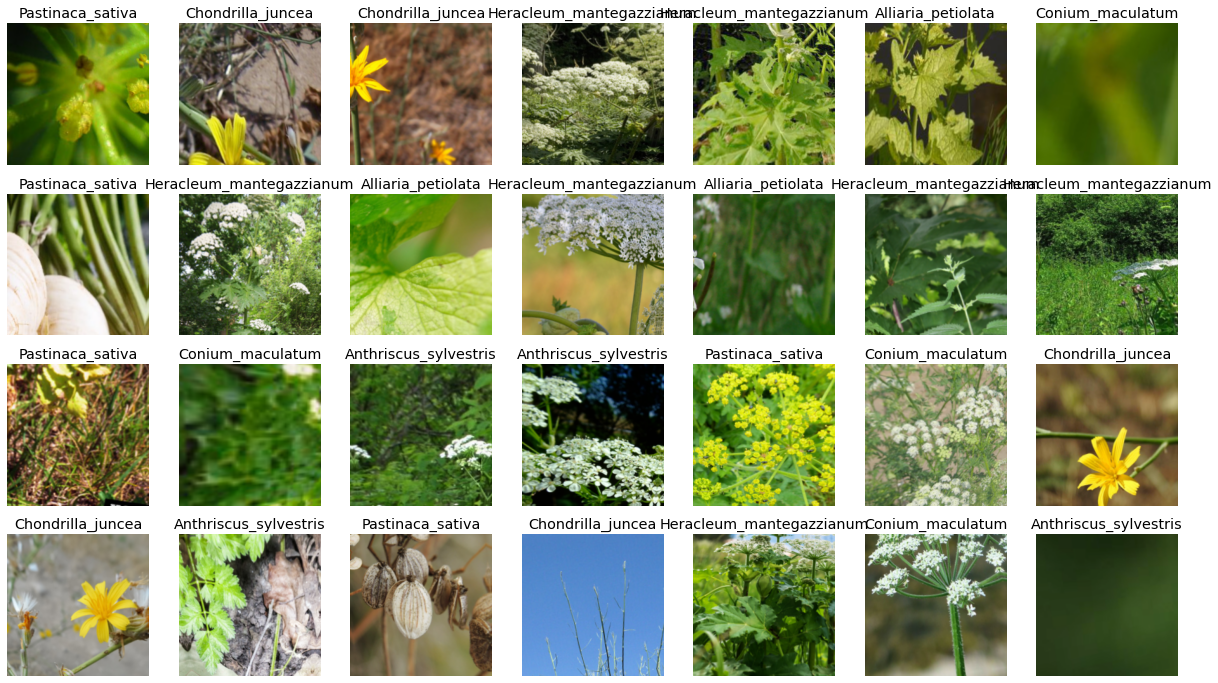

In [51]:
# Create data loader with benchmark parameters from "plants" DataBlock created above
plants = plants.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.01, max_scale=0.5),
    batch_tfms=aug_transforms())
dls = plants.dataloaders(path)
dls.train.show_batch(max_n=28, nrows=4, unique=False)

In [37]:
# Fine tune the model to handle the image data we've collected and augmented
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

#### error rate of ~25% to start off, not too bad without additional data augmentation tuning!
#### Let's just take a look at if resnet34 or 50 do better off the bat

#### First the resnet34 model

In [38]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(10)

#### Now the resnet50 model

In [39]:
learn = vision_learner(dls, resnet50, metrics=error_rate)
learn.fine_tune(10)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

#### Resnet50 didn't out perform 34, so we'll stick to 34 for our current use-case, tuning hyperparameters from there.

In [52]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(8)

#### Now let's see what mistakes the model is making. To visualize this, we can create a *confusion matrix*:

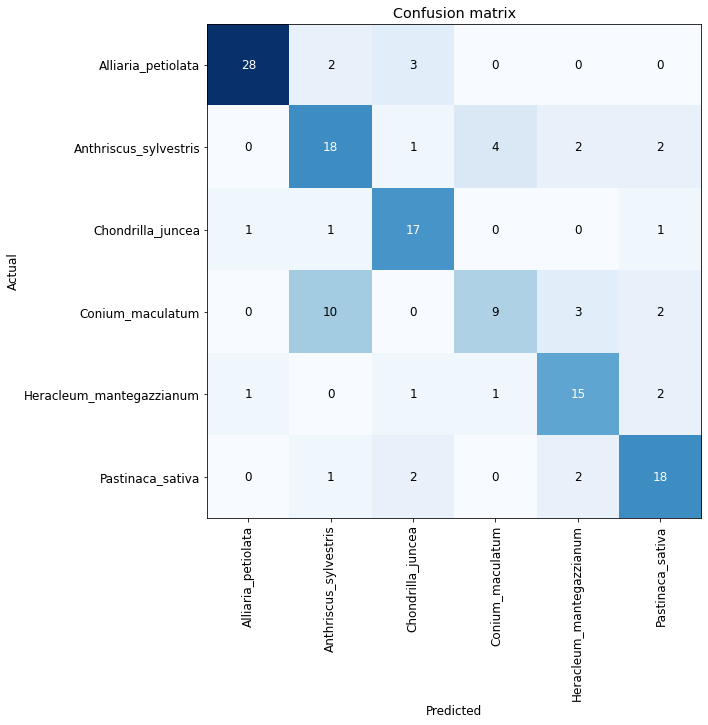

In [54]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10, 10))

What we want to see here is a dark blue diagonal line across the whole chart, as those represent correctly identified images to their labels. We can see that for `alliaria petiolata`, `chondrilla juncea`, `heraclieum mantegazzianum`, and `pastinaca sativa`, they are mostly being predicted correctly. However, the model is struggling with identifying both `anthriscus sylvestris` and `conium maculatum`. Let's investigate why by pulling in what these two plants actually look like.



image of Anthriscus_sylvestris


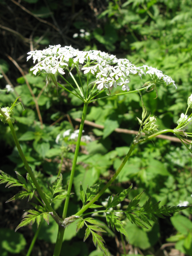

In [68]:
# print thumbnail of anthriscus image in dataset
dest = '/notebooks/invasive_plant_identifier/images/Anthriscus_sylvestris/00000000.JPG'
im = Image.open(dest)
print('image of Anthriscus_sylvestris')
im.to_thumb(128*2,128*2)

image of Conium_maculatum


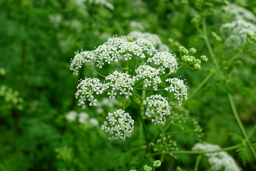

In [69]:
# print thumbnail of random conium image in dataset
dest = '/notebooks/invasive_plant_identifier/images/Conium_maculatum/00000000.jpg'
im = Image.open(dest)
print('image of Conium_maculatum')
im.to_thumb(128*2,128*2)

#### We can clearly see now why the model is struggling with these two species of plants, they look almost identical! Further searing in google for images of "Wild Chevril" and "Poison Hemlock" will validate this notion. 

#### A quote from a popular plant blog, "The leaves of poison hemlock look very similar to chervil", this is the case as both species belong to the Apiaceae family

#### I think the best move forward is to see if we can improve our data collection. It seems that the 6 chosen plants are all flower producing, and it is likely that user-submitted pictures would also be flower containing. I think it's in our best interest then, to try and recreate the image dataset only using flower pictures of the plants of interest. This will get rid of noise from foliage or vegetative structure of the plants, and should refine our dataset (but we will see!)


In [83]:
# Create new directory for all target plants, saving 150 search result images of each plant's flowers in folders of their own name 
# This may take several minutes to complete depending on how many categories you are scraping for

path=Path('/notebooks/invasive_plant_identifier/images_w_flowers/')

if not path.exists():
    path.mkdir()
    for p in invasive_pc:
        dest = (path/p)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, (f'{p} flower').replace("_", ""), max_images=150)
        download_images(dest, urls=results.attrgot('contentUrl'))

#### Now to go through the same process of finding failed images and unlinking them, then seeing how many images remain

In [93]:
fns = get_image_files(path)
failed = verify_images(fns)
len(failed)

0

In [94]:
failed.map(Path.unlink)
failed = len(failed)

In [96]:
print(f'remaining corrupted images: {failed}')
for p in invasive_pc:
    print(f'{p} has {len(get_image_files(path/p))} images --> {150 - len(get_image_files(path/p))} images were removed')

remaining corrupted images: 0
Alliaria_petiolata has 146 images --> 4 images were removed
Heracleum_mantegazzianum has 143 images --> 7 images were removed
Conium_maculatum has 140 images --> 10 images were removed
Chondrilla_juncea has 133 images --> 17 images were removed
Anthriscus_sylvestris has 146 images --> 4 images were removed
Pastinaca_sativa has 140 images --> 10 images were removed


#### Less failed images this time, and hopefully more accurate searches, should lead to an improved model 
#### Let's go back through the training steps on this new data

In [97]:
# Check if path is pointing to right directory
path

Path('/notebooks/invasive_plant_identifier/images_w_flowers')

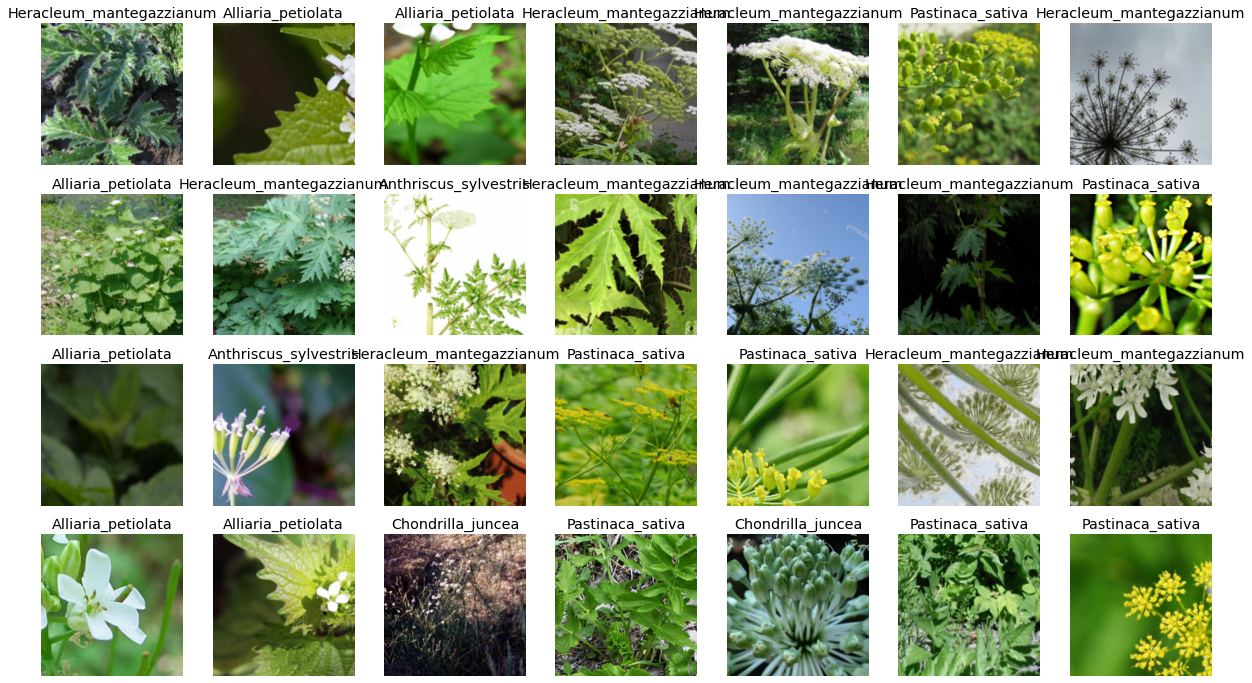

In [98]:
# Create data loader with still benchmark parameters from "plants" DataBlock created above
plants = plants.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.01, max_scale=0.5),
    batch_tfms=aug_transforms())
dls = plants.dataloaders(path)
dls.train.show_batch(max_n=28, nrows=4, unique=False)

In [99]:
# Fine tune the model to handle the image data we've collected and augmented
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(10)

#### Right off the bat, without any additional tuning, the improved dataset is performing better. Still have lots of room for improvement, but we're off to a good start here. Let's take a look at our correlation matrix again

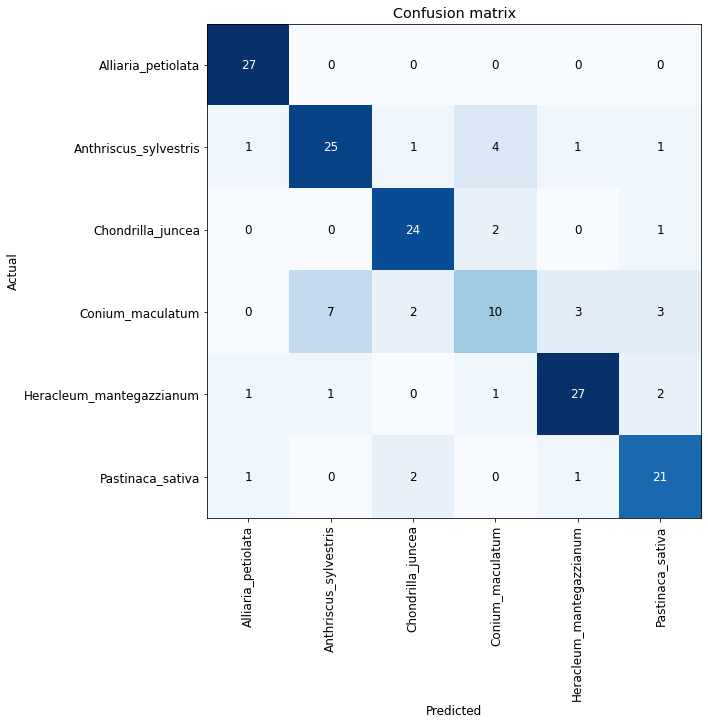

In [100]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10, 10))

#### Looks like the model is doing much better at classifying antriscus sylvestris, but still struggling with conium maculatum. Still, we're seeing a huge improvement over the original dataset classification
#### Let's get into some hyperparameter tuning below

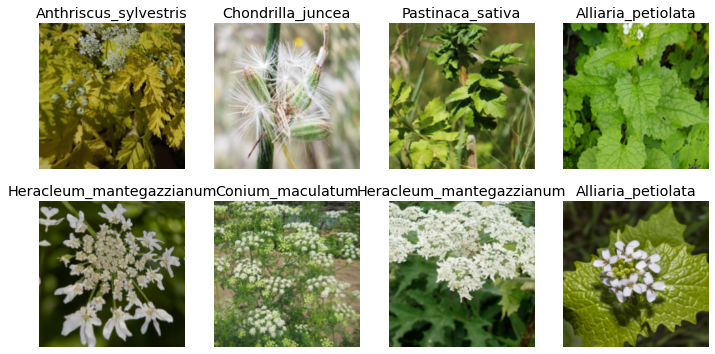

In [255]:
# here are the parameters from the benchmark
# plants = plants.new(
#     item_tfms=RandomResizedCrop(224, min_scale=0.5),
#     batch_tfms=aug_transforms())

# here are the changes, adding in flip, rotate, and zoom to aug_transforms
plants = plants.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = plants.dataloaders(path)

# Quick check to make sure images aren't going crazy with the transforms
dls.train.show_batch(max_n=8, nrows=2, unique=False)

In [256]:
# Finetune the model, hoping to beat the 20% error rate from before
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

It's helpful to see where exactly our errors are occurring, to see whether they're due to a dataset problem (e.g., images that aren't plants at all, or are labeled incorrectly, etc.), or a model problem (perhaps it isn't handling images taken with unusual lighting, or from a different angle, etc.). To do this, we can sort our images by their *loss*.

The loss is a number that is higher if the model is incorrect (especially if it's also confident of its incorrect answer), or if it's correct, but not confident of its correct answer. In a couple of chapters we'll learn in depth how loss is calculated and used in the training process. For now, `plot_top_losses` shows us the images with the highest loss in our dataset. As the title of the output says, each image is labeled with four things: prediction, actual (target label), loss, and probability. The *probability* here is the confidence level, from zero to one, that the model has assigned to its prediction:

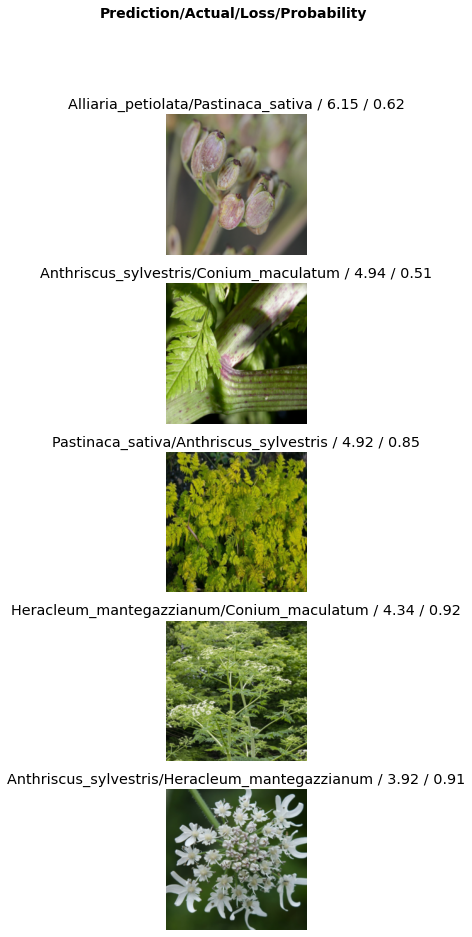

In [217]:
interp.plot_top_losses(5, nrows=5)

#### The intuitive approach to doing data cleaning is to do it *before* you train a model. But as you've seen in this case, a model can actually help you find data issues more quickly and easily. So, we normally prefer to train a quick and simple model first, and then use it to help us with data cleaning.

#### fastai includes a handy GUI for data cleaning called `ImageClassifierCleaner` that allows you to choose a category and the training versus validation set and view the highest-loss images (in order), along with menus to allow images to be selected for removal or relabeling:

In [109]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [108]:
# delete and move all images labelled for delete or recategorized
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

We can see that amongst our "black bears" is an image that contains two bears: one grizzly, one black. So, we should choose `<Delete>` in the menu under this image. `ImageClassifierCleaner` doesn't actually do the deleting or changing of labels for you; it just returns the indices of items to change. So, for instance, to delete (`unlink`) all images selected for deletion, we would run:

```python
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
```

To move images for which we've selected a different category, we would run:

```python
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)
```

> s: Cleaning the data and getting it ready for your model are two of the biggest challenges for data scientists; they say it takes 90% of their time. The fastai library aims to provide tools that make it as easy as possible.

We'll be seeing more examples of model-driven data cleaning throughout this book. Once we've cleaned up our data, we can retrain our model. Try it yourself, and see if your accuracy improves!

> note: No Need for Big Data: After cleaning the dataset using these steps, we generally are seeing 100% accuracy on this task. We even see that result when we download a lot fewer images than the 150 per class we're using here. As you can see, the common complaint that _you need massive amounts of data to do deep learning_ can be a very long way from the truth!

Now that we have trained our model, let's see how we can deploy it to be used in practice.

## Deplyoying Model as an Online Application (gradio)

We are now going to look at what it takes to turn this model into a working online application.

### Using the Model for Inference

Once you've got a model you're happy with, you need to save it, so that you can then copy it over to a server where you'll use it in production. Remember that a model consists of two parts: the *architecture* and the trained *parameters*. The easiest way to save the model is to save both of these, because that way when you load a model you can be sure that you have the matching architecture and parameters. To save both parts, use the `export` method.

This method even saves the definition of how to create your `DataLoaders`. This is important, because otherwise you would have to redefine how to transform your data in order to use your model in production. fastai automatically uses your validation set `DataLoader` for inference by default, so your data augmentation will not be applied, which is generally what you want.

When you call `export`, fastai will save a file called "export.pkl":

In [106]:
learn.export('/notebooks/invasive_plant_identifier/invsv_export.pkl')

Let's check that the file exists, by using the `ls` method that fastai adds to Python's `Path` class:

In [107]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('invsv_export.pkl')]

You'll need this file wherever you deploy your app to. For now, let's try to create a simple app within our notebook.

When we use a model for getting predictions, instead of training, we call it *inference*. To create our inference learner from the exported file, we use `load_learner` (in this case, this isn't really necessary, since we already have a working `Learner` in our notebook; we're just doing it here so you can see the whole process end-to-end):

In [108]:
learn_inf = load_learner(path/'invsv_export.pkl')

When we're doing inference, we're generally just getting predictions for one image at a time. To do this, pass a filename to `predict`:

In [109]:
learn_inf.predict('/notebooks/invasive_plant_identifier/test/test2.jpg')

('Chondrilla_juncea',
 TensorBase(2),
 TensorBase([0.0101, 0.0360, 0.5331, 0.3576, 0.0347, 0.0285]))

This has returned three things: the predicted category in the same format you originally provided (in this case that's a string), the index of the predicted category, and the probabilities of each category. The last two are based on the order of categories in the *vocab* of the `DataLoaders`; that is, the stored list of all possible categories. At inference time, you can access the `DataLoaders` as an attribute of the `Learner`:

In [110]:
learn_inf.dls.vocab

['Alliaria_petiolata', 'Anthriscus_sylvestris', 'Chondrilla_juncea', 'Conium_maculatum', 'Heracleum_mantegazzianum', 'Pastinaca_sativa']

We can see here that if we index into the vocab with the integer returned by `predict` then we get back "grizzly," as expected. Also, note that if we index into the list of probabilities, we see a nearly 1.00 probability that this is a grizzly.

We know how to make predictions from our saved model, so we have everything we need to start building our app. We can do it directly in a Jupyter notebook.

### Creating a Notebook App from the Model